In [9]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../'))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.model_selection import cross_val_score
from Audio_Sentiment_Analysis.utils.Configuration import Configuration

In [2]:
EXTRACTED_FEATURES_FILE = 'extracted_features_ent05.csv'
SCALED_FEATURES = 'scaled_features.csv'
CONFIG_FILE = f"{os.path.abspath('./../../')}/Audio_Sentiment_Analysis/data/config.json"
config = Configuration.load_json(CONFIG_FILE)
pd.options.display.max_columns = None

In [3]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(df.shape)
df = df.sort_values(['Subject', 'Emotion', 'Gender'], ascending = (True, True, True))
df = df.set_index('Subject')
df

(1287, 41)


,File,Gender,Emotion,Emotion_Id,mel_mean,mel_min,mel_max,mel_var,mel_std,mean_chroma_stft,mean_rms,mean_spectral_centroid,mean_spectral_contrast,mean_spectral_bandwidth,mean_spectral_rolloff,mean_zero_crossing_rate,var_zero_crossing_rate,std_zero_crossing_rate,spikes_zero_crossing_rate,sum_zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
Subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,s1_an_1,m,anger,0,5.470246,4.425599e-10,2683.060303,2835.492676,53.249344,0.402497,0.129479,1814.026368,22.718679,1834.495092,3811.157227,0.093647,0.001995,0.044666,6,13.766113,-171.056549,115.938042,-28.566433,21.314878,-26.507704,10.144446,-22.394417,-6.446075,-20.058737,-9.614692,-15.731797,-8.805966,-2.915169,-12.226694,-5.387331,-4.913488,-9.523164,-1.791623,-3.507744,0.083974
1,s1_an_2,m,anger,0,4.795432,3.266728e-10,1598.459473,1602.659546,40.033230,0.369817,0.122001,1813.929245,22.243432,1772.517500,3602.609923,0.095251,0.004444,0.066661,8,11.715820,-187.978119,114.721764,-41.258282,22.174334,-12.715221,11.881121,-22.636301,-9.284859,-23.113136,-7.031469,-15.980973,-11.601790,-5.727098,-6.378960,-7.155036,-7.385511,-8.306025,4.346861,-6.595266,-2.742662
1,s1_an_5,m,anger,0,6.344573,4.247520e-10,4932.327637,6391.681152,79.947990,0.312011,0.140534,1577.596083,23.661057,1621.112545,3149.887457,0.072095,0.000541,0.023251,4,8.867676,-180.083939,119.054886,-42.182270,26.999893,-6.590928,8.636041,-17.951387,-20.642817,-24.792250,-4.610571,-18.438587,-11.906024,-3.913879,-11.295942,-3.214928,-6.571509,-0.506520,1.930403,-6.855784,-2.346526
1,s1_an_4,m,anger,0,7.300478,3.510179e-10,3062.532715,4610.922363,67.903770,0.272837,0.155781,1578.663080,23.566948,1679.770568,3222.159447,0.068912,0.000354,0.018807,0,7.304688,-166.445877,122.271973,-42.199047,19.365204,-21.122906,8.933196,-21.792807,-10.018277,-22.990005,-9.038509,-19.050367,-9.762544,0.404813,-14.561901,-6.730536,-4.809193,-5.546733,2.948940,-6.117626,-3.003350
1,s1_an_3,m,anger,0,3.334237,3.032449e-10,689.850098,542.464478,23.290867,0.402758,0.093039,1699.189320,21.846660,1764.541591,3558.226103,0.089708,0.000406,0.020160,0,10.675293,-241.878052,123.269180,-36.750164,15.108225,-17.863935,12.198894,-16.139629,-8.320073,-9.156641,-3.037857,-7.307014,-2.118013,-5.378597,-6.666719,-4.749491,-4.346241,-5.281549,3.802923,-7.263710,3.085279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,s43_su_1,m,surprise,5,0.769080,7.201543e-10,343.847076,67.194626,8.197233,0.331168,0.044888,2052.206978,21.497085,2161.771189,4606.111654,0.079783,0.001808,0.042515,6,6.462402,-336.866089,92.766159,-11.945115,21.954580,-17.095549,14.651039,-26.619286,-25.634380,-13.413041,-14.144950,-5.024630,6.116760,-10.426900,0.831624,2.825282,-2.409575,-10.828929,-1.298723,-8.621070,-5.182372
43,s43_su_2,m,surprise,5,0.556107,5.498184e-10,230.432190,23.537956,4.851593,0.380171,0.039031,2454.031082,20.405096,2270.482310,5048.431866,0.118452,0.006708,0.081905,6,9.239258,-319.413849,81.346947,-16.686415,29.972387,-6.042556,16.341099,-33.199039,-16.532486,-12.359122,-4.888298,-6.806831,-1.223010,-10.650027,1.095915,-2.858048,-0.077681,-17.657351,0.739707,-8.174618,-4.075395
43,s43_su_5,m,surprise,5,0.360079,4.762937e-10,329.025574,26.714954,5.168651,0.457406,0.025236,2454.743336,19.416661,2309.675541,4884.228516,0.131743,0.012873,0.113460,9,19.366211,-417.796600,86.241020,12.699595,22.715195,-1.217471,10.950769,-8.263742,-3.265463,-9.827182,-1.790178,-4.792536,-2.122405,-5.465124,0.598570,-3.640218,0.477983,-7.970364,-2.126075,-4.782431,-4.928042


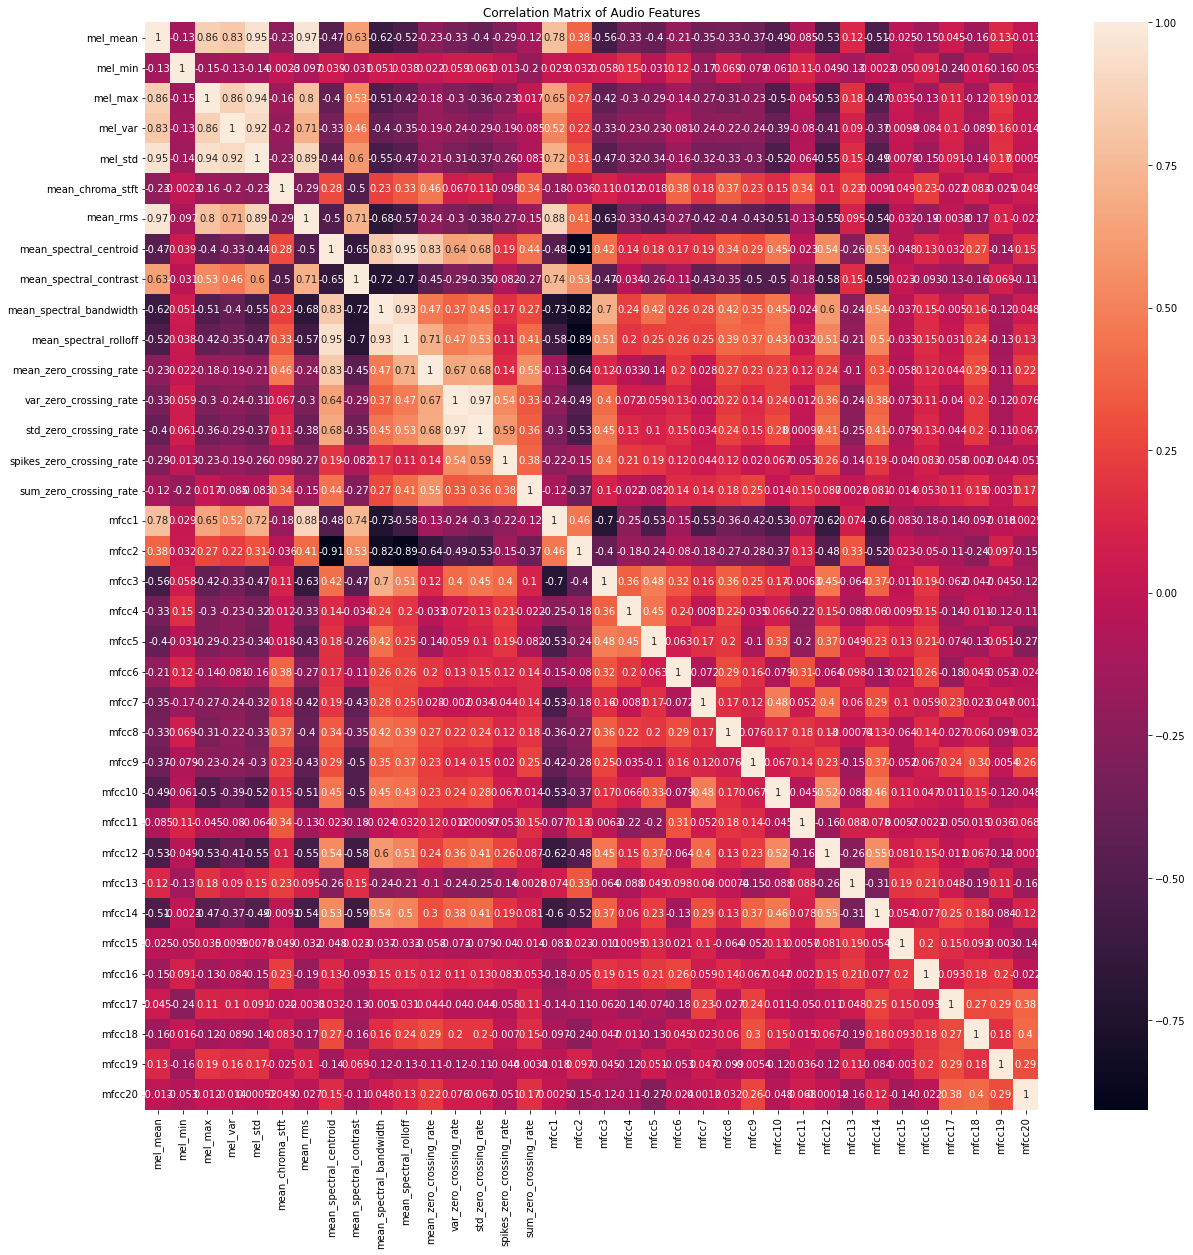

In [4]:
plt.figure(figsize=(20,20))
plt.title("Correlation Matrix of Audio Features")
plt.xlabel("Audio Features")
plt.ylabel("Audio Features")
df_corr = df.iloc[:,4:].corr()
sns.heatmap(df_corr, annot=True)
plt.show()

In [5]:
corr_pairs = df_corr.unstack()
strong_pairs = []

for pair in corr_pairs.items():
    if pair[0][0] != pair[0][1] and abs(pair[1]) > 0.85\
        and ((pair[0][1], pair[0][0]), pair[1]) not in strong_pairs:
        strong_pairs.append(((pair[0][0], pair[0][1]), pair[1]))

strong_pairs.sort(reverse=True, key=lambda x: abs(x[1]))
strong_pairs

[(('var_zero_crossing_rate', 'std_zero_crossing_rate'), 0.9687908497391192),
 (('mel_mean', 'mean_rms'), 0.9650768839278535),
 (('mel_mean', 'mel_std'), 0.951822616694623),
 (('mean_spectral_centroid', 'mean_spectral_rolloff'), 0.9455765683444296),
 (('mel_max', 'mel_std'), 0.9436426129590605),
 (('mean_spectral_bandwidth', 'mean_spectral_rolloff'), 0.9288031385882548),
 (('mel_var', 'mel_std'), 0.9153066805022055),
 (('mean_spectral_centroid', 'mfcc2'), -0.9066889025945236),
 (('mel_std', 'mean_rms'), 0.893645193764168),
 (('mean_spectral_rolloff', 'mfcc2'), -0.8892568706257424),
 (('mean_rms', 'mfcc1'), 0.8810882411131383),
 (('mel_max', 'mel_var'), 0.8592864364742951),
 (('mel_mean', 'mel_max'), 0.8575234861247634)]

In [30]:
def feature_test(data, labels, features):
    feature_results = {}

    # drop each feature and test the model performance without it
    for feature in features:
        temp_data = data.copy()
        temp_data.drop(feature, inplace=True, axis=1)

        X = temp_data.values

        clf = tree.DecisionTreeClassifier()
        clf = clf.fit(X, labels)
        scores = cross_val_score(clf, X, labels, cv=5)

        mean_score = np.mean(scores)
        std_score = np.std(scores)
        feature_results[feature] = [mean_score, std_score]

    return feature_results

In [31]:
data = df.iloc[:,4:]
features = df.columns.values[4:]
labels = df["Emotion_Id"].values

feature_results = feature_test(data, labels, features)

In [32]:
feature_results

{'mel_min': [0.2874852954483757, 0.03636458484231568],
 'mel_max': [0.27581817633396677, 0.030578039610856377],
 'mel_var': [0.292148523512201, 0.020951865277253883],
 'mel_std': [0.2843905528911411, 0.018860542565423955],
 'mean_chroma_stft': [0.2944952191355231, 0.015227584631955247],
 'mean_rms': [0.2882665218833892, 0.013311571333642594],
 'mean_spectral_centroid': [0.28588966307724795, 0.03108090877074574],
 'mean_spectral_contrast': [0.2657436732724037, 0.021182339907117105],
 'mean_spectral_bandwidth': [0.28208005308720174, 0.0360110641324245],
 'mean_spectral_rolloff': [0.2781769372304165, 0.027152585554947383],
 'mean_zero_crossing_rate': [0.25488794377582724, 0.03145033885177726],
 'var_zero_crossing_rate': [0.2797303411455977, 0.02734047928622656],
 'std_zero_crossing_rate': [0.2812867613790607, 0.01584362631664403],
 'spikes_zero_crossing_rate': [0.282040840949537, 0.02497481665487683],
 'sum_zero_crossing_rate': [0.29141254185141613, 0.05548349164975623],
 'mfcc1': [0.2968